In [1]:
%load_ext autoreload
%autoreload 2

In [78]:
%matplotlib widget

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import xarray as xr

In [4]:
from neurodsp.plts.time_series import plot_time_series
from ripple_detection.core import gaussian_smooth
smoothing_sigma = 2 # seconds

In [6]:
from ecephys.data import channel_groups, paths
from ecephys.sglx_utils import load_timeseries
from ecephys.signal.timefrequency import parallel_spectrogram_welch
from ecephys.plot import plot_spectrogram, plot_hypnogram_overlay
from ecephys.scoring import load_visbrain_hypnogram

In [55]:
start_time = 0
end_time = None
bin_path = paths.get_datapath(subject="Doppio", condition="REC-2", data="lf.bin")

In [ ]:
hypno_path = paths.get_datapath(subject="Doppio", condition="REC-2", data="hypnogram.txt")
hypno = load_visbrain_hypnogram(hypno_path)

In [57]:
delta_range = (0.5, 4)
theta_range = (5, 10)

In [58]:
def get_spectrogram(sig):
    freqs, spg_times, spg = parallel_spectrogram_welch(sig.values, sig.fs)
    spg_times = spg_times + start_time
    spg = xr.DataArray(spg, dims=("frequency", "time", "channel"), coords={"frequency": freqs, "time": spg_times, "channel": sig.channel.values})
    return spg.median(dim="channel")
    
def _get_bandpower(spg, f_range, chans):
    bandpower = spg.sel(frequency=slice(*f_range)).sum(dim="frequency")
    bandpower.attrs['long_name'] = "{} Hz PSD".format(f_range)
    bandpower.attrs['units'] = 'uV^2/Hz'
    bandpower.attrs['chans'] = chans
    bandpower.attrs['freq_range'] = f_range
    
    return bandpower

## Cortex

In [59]:
cx_chans = channel_groups.superficial_ctx["Doppio"]
cx_sig = load_timeseries(bin_path, cx_chans, start_time=start_time, end_time=end_time, xarray=True)

nChan: 385, nFileSamp: 18000019


In [60]:
cx_spg = get_spectrogram(cx_sig)

In [61]:
cx_theta = _get_bandpower(cx_spg, theta_range, cx_chans)
cx_delta = _get_bandpower(cx_spg, delta_range, cx_chans)

### Plot

In [79]:
plot_spectrogram(cx_spg.frequency, cx_spg.time, cx_spg, yscale='log')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

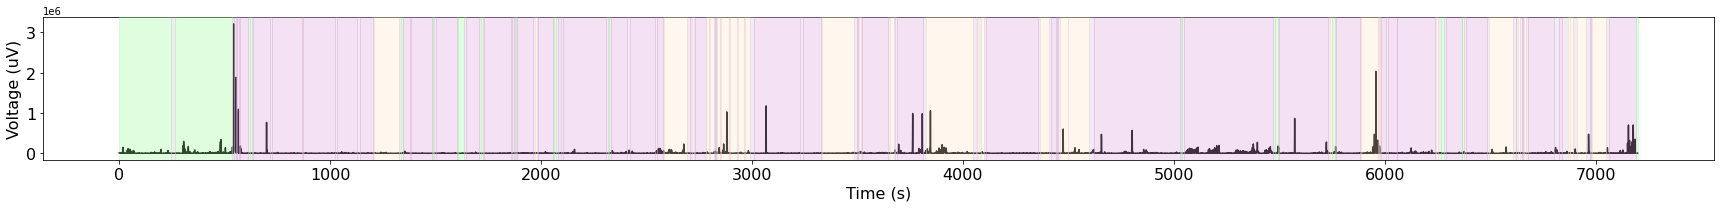

In [63]:
_, ax = plt.subplots(figsize=(24, 3))
plot_time_series(cx_spg.time.values, cx_delta.values, ax=ax)
plot_hypnogram_overlay(hypno, ax=ax)

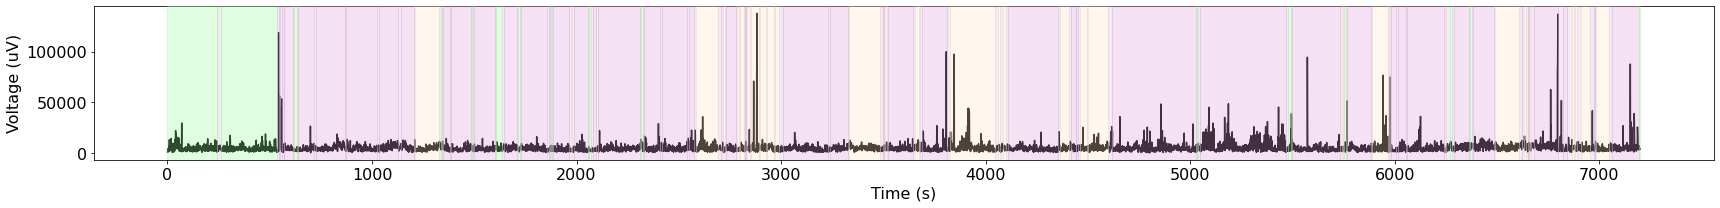

In [64]:
_, ax = plt.subplots(figsize=(24, 3))
plot_time_series(cx_spg.time.values, cx_theta.values, ax=ax)
plot_hypnogram_overlay(hypno, ax=ax)

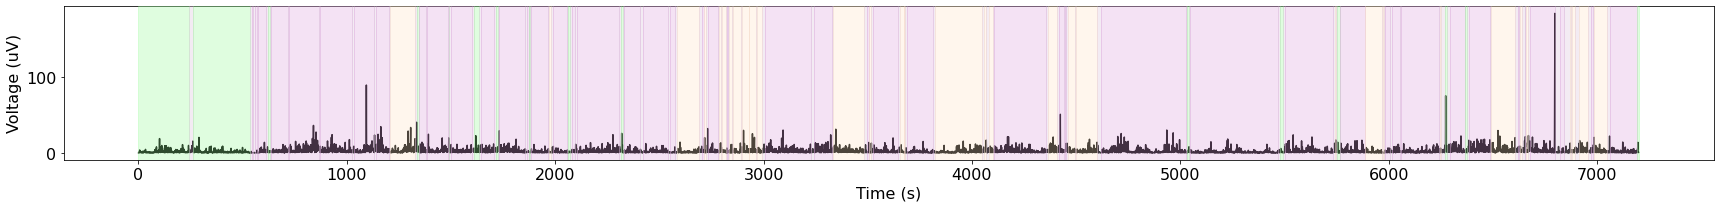

In [65]:
_, ax = plt.subplots(figsize=(24, 3))
plot_time_series(cx_spg.time.values, cx_theta.values / cx_delta.values, ax=ax)
plot_hypnogram_overlay(hypno, ax=ax)

## Theta

In [66]:
sr_chans = channel_groups.stratum_radiatum_140um_to_200um["Doppio"]
sr_sig = load_timeseries(bin_path, sr_chans, start_time=start_time, end_time=end_time, xarray=True)

nChan: 385, nFileSamp: 18000019


In [67]:
sr_spg = get_spectrogram(sr_sig)

In [68]:
sr_theta = _get_bandpower(sr_spg, theta_range, sr_chans)
sr_delta = _get_bandpower(sr_spg, delta_range, sr_chans)

### Plot

In [80]:
plot_spectrogram(sr_spg.frequency, sr_spg.time, sr_spg, yscale='log')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [86]:
_, ax = plt.subplots(figsize=(20, 3))
plot_time_series(sr_spg.time.values, sr_delta.values, ax=ax)
#plot_hypnogram_overlay(hypno, ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [85]:
_, ax = plt.subplots(figsize=(20, 3))
plot_time_series(sr_spg.time.values, sr_theta.values, ax=ax)
#plot_hypnogram_overlay(hypno, ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [84]:
_, ax = plt.subplots(figsize=(20, 3))
plot_time_series(sr_spg.time.values, sr_theta.values / sr_delta.values, ax=ax)
#plot_hypnogram_overlay(hypno, ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [83]:
_, ax = plt.subplots(figsize=(20, 3))
plot_time_series(sr_spg.time.values, np.log10(sr_theta.values) / np.log10(sr_delta.values), ax=ax)
#plot_hypnogram_overlay(hypno, ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

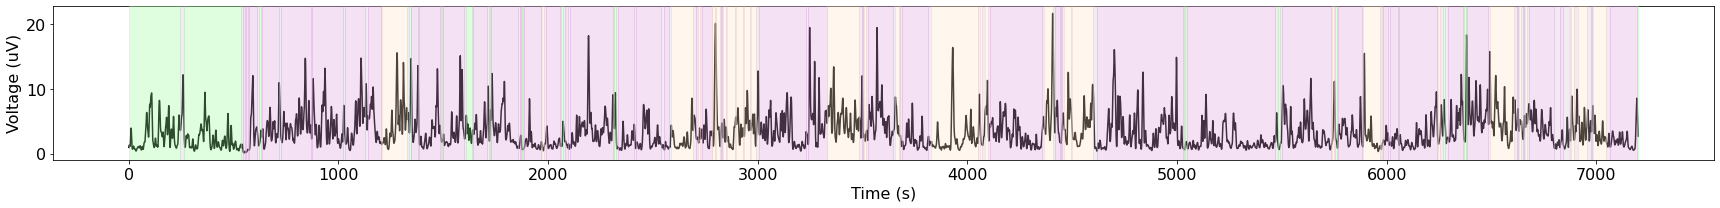

In [73]:
_, ax = plt.subplots(figsize=(24, 3))
plot_time_series(sr_spg.time.values, gaussian_smooth(sr_theta.values / sr_delta.values, smoothing_sigma, 1 / np.diff(sr_spg.time.values).mean()) , ax=ax)
plot_hypnogram_overlay(hypno, ax=ax)

## Save

In [74]:
bandpower = xr.Dataset({'mpta_delta': cx_delta, 'mpta_theta': cx_theta, 'sr_delta': sr_delta, 'sr_theta': sr_theta})

In [77]:
bandpower.to_netcdf(paths.get_datapath(subject="Doppio", condition="REC-2", data="lfp_bandpower.nc"))